<a href="https://colab.research.google.com/github/mayureshagashe2105/GSoC-22-TensorFlow-Resources-and-Notebooks/blob/main/Pseudo%20Segmentation%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

This notebook presents an exhuastive overview about working with the subset of the original [`prostate-cancer-grade-assessment`](https://www.kaggle.com/competitions/prostate-cancer-grade-assessment) dataset. The following tasks can be achieved with the this notebook.
1. EDA on the subset.
2. Building custom DataGenerators to build efficient data loading pipelines.
3. Benchmarking the DataGenerators.
4. Model Building.
5. Inference with pseudo slide Segmentation map.

# Dependencies

The dataset chosen for this task contains images of the slides (tissues extracted from the biopsy) in `tiff` format. Hence, to work with these images we will be using the `openslide` python package.
```sh
NOTE: While trying to install the said package I ran across multiple errors. Upon further reading of the GitHub issues, I came to know that the openslide python package needs some dlls from the openslide C library. 
```
More information about this can be found in [#35](https://github.com/openslide/openslide-python/issues/35) GitHub issue.

In [1]:
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (90.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debcon

In [2]:
import shutil
import os
import glob
from IPython.display import Image, display
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from tqdm import tqdm
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import openslide

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.utils as ku
import tensorflow_datasets as tfds


from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Setting up the directory structure

In [4]:
__zipped_dir = "/content/gdrive/MyDrive/GSoC'22 @ TensorFlow/Panda Subset 3 GB.zip"
__extract_dir = "/content/PANDA_subset"
if not os.path.exists(__extract_dir):
  os.mkdir(__extract_dir)
shutil.unpack_archive(__zipped_dir, __extract_dir, 'zip')

In [5]:
BASE_DIR = __extract_dir
IMAGES_DIR = os.path.join(BASE_DIR, 'train_images_subset')
MASK_DIR = os.path.join(BASE_DIR, 'train_masks_subset')

# EDA

In [6]:
train_data = pd.read_csv(os.path.join(BASE_DIR, 'train_subset.csv'))
train_data.head()

,image_id,data_provider,isup_grade,gleason_score,mask_file_name
0,6f8a4164d3e4d3d168d51cc090ee7723,karolinska,0,0+0,6f8a4164d3e4d3d168d51cc090ee7723_mask.tiff
1,81adb00db7e7b3034900a1f95a4dc257,radboud,1,3+3,81adb00db7e7b3034900a1f95a4dc257_mask.tiff
2,cb88fb1e0305ba94d8186a245ac2193b,karolinska,2,3+4,cb88fb1e0305ba94d8186a245ac2193b_mask.tiff
3,a7f00efad38057d7c04273206366b682,karolinska,3,4+3,a7f00efad38057d7c04273206366b682_mask.tiff
4,fd412a8f537036702bb0e3fa3160f336,karolinska,4,4+4,fd412a8f537036702bb0e3fa3160f336_mask.tiff


In [7]:
train_df_copy = train_data.copy()
train_df_copy['image_id'] = train_df_copy['image_id'] + '.tiff'
train_df_copy = train_df_copy.set_index('image_id')

In [8]:
train_df, validation_df = train_test_split(train_data, test_size=0.2)

In [9]:
train_df.reset_index(inplace=True)

In [10]:
validation_df.reset_index(inplace=True)

In [11]:
class EDAUtilFunctions:
    """Utility class with different data visualization functions.
    
    Args:
        dataframe: pd.DataFrame. Pandas DataFrame object on which EDA is to be performed.
    """
    
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe
    
    def count_plot(self, col_names: list):
      
        """plots a count plot for column names passed as the parameter.
        
        Args:
            col_names: list of str. Names of the columns for which the count plot has to be made.
        
        Riases:
            KeyError: If any value from the col_names list is not a valid column name.
        """
        
        plt.figure(figsize=(8,6), tight_layout=True)
        colors = sns.color_palette('pastel')

        for col_name in col_names:
        
            if col_name not in self.df.columns:
                raise KeyError(f'{col_name} should be present in {self.df.columns}')

            

            unique_features, counts = np.unique(self.df[col_name], return_counts=True)

            plt.bar(unique_features, counts, color=colors[:len(unique_features)])
            plt.xticks(rotation=90)
            plt.xlabel(col_name)
            plt.ylabel('Count')
            plt.title('Count Plot')
            plt.show()

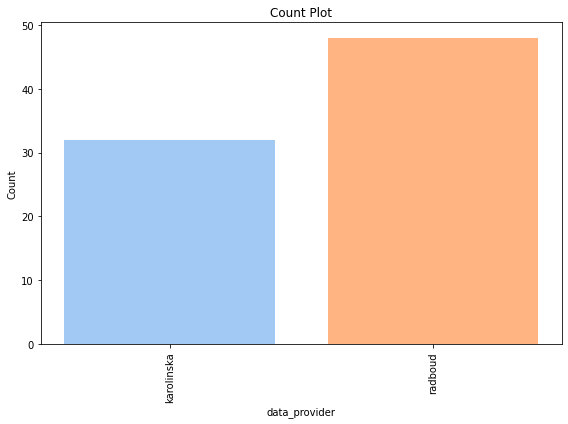

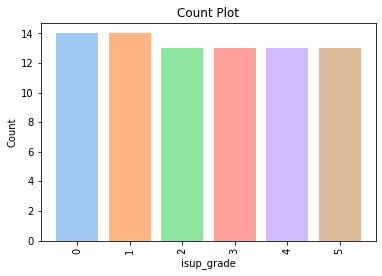

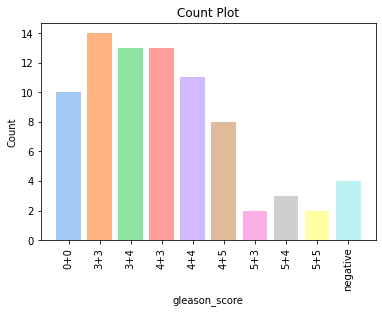

In [12]:
eda_df = EDAUtilFunctions(train_data)
eda_df.count_plot(['data_provider', 'isup_grade', 'gleason_score'])

# Working with the `tiff` files

TIFF is a short form of "Tagged Image Format" containing an image file of high-quality graphics format. TIFF files have multiple index levels which represent different resolutions of the same image. In this dataset, all the tiff images have 3 index levels viz. 0, 1, and 2, where index level 0 is the highest resolution of the image and 2 is the level with the least resolution. 
Each slide has 3 levels you can load, corresponding to downsampling of 1, 4, and 16. Intermediate levels can be created by downsampling a higher resolution level.
This image below represents how index levels work.
<center><img src="https://iipimage.sourceforge.io/images/pyramid.png" alt="index level representation"></img></center>





## Reading the tiff file
```python
    # Open the image (does not yet read the image into memory)
    image = openslide.OpenSlide('path_of_the_slide')

    # Read a specific region of the image starting at coordinate (x=0, y=0) on level 0 and extracting a 256*256 pixel patch.
    # At this point image data is read from the file and loaded into memory.
    patch = image.read_region((0, 0) 0, (256, 256))

    # Display the image
    display(patch)

    # Close the opened slide after use
    image.close()
```

[Info Source](https://www.kaggle.com/code/wouterbulten/getting-started-with-the-panda-dataset)

#### About the masks in the dataset
The Authors of the dataset have provided masks for most of the slides. However, the information of the mask i.e the encoding is embedded in the R channel of the mask image and the other 2 channels viz. G & B can be ignored.

In [13]:
class TIFFVisualization:
    """"Utility Class to visualize the tiff files(biopsy slides) and their corresponding 
        masks provided by the dataset authors.
    """
    
    @staticmethod
    def visualize_patch(patch_shape: tuple, n_images: int, pos: tuple, img_dir: str, dft: pd.DataFrame, index_level: int):
      
        """Displays a patch of the slide of the given size from the given position from a given level
        
        Args:
            patch_shape: tuple. 2D-tuple. (x-length, y-length). Desired patch size from the entire slide.
            n_images: int. Number of images to visualize and to extract a patch from.
            pos: tuple. 2D-tuple. (x-corr, y-corr). Coordinates from which a patch of size `patch_size` is to be extracted.
            img_dir: str. Direcotry path where all the training images are present.
            dft: pd.DataFrame. Pandas DataFrame object that contains information about each image in the image directory.
            index_level: int. Should be in the range[0, 2]. Indicates from which resolution level the patch has to be extracted.
        
        Raises:
            RuntimeError: If `img_dir` does not contain any `tiff` images.
            RuntimeError: If `index_level` is out of the range [0, 2].
            AssertionError: if `patch_shape` is not a 2D tuple.
            AssertionError: if `pos` is not a 2D tuple.
        """
        

        filenames = glob.glob(f'{img_dir}/*.tiff')
        
        if len(filenames) is 0:
            raise RuntimeError(f'{img_dir} should contain tiff encoded images')
        
        if 0 > index_level > 2:
          raise RuntimeError(f'{index_level} should be in the range [0, 2]')
        
        assert len(pos) == 2, "pos should be a 2D tupple"
        assert len(patch_shape) == 2, "patch_shape should be a 2D tupple"

        
        
        
        indices = np.random.randint(0, len(filenames), n_images)
        
        fig, axes = plt.subplots(n_images // 3, 3, figsize=(20, 60))
        for i in range(n_images):
            key_name = filenames[indices[i]].split('/')[-1]
            slide = openslide.OpenSlide(filenames[indices[i]])
            patch = slide.read_region(pos, 2, patch_shape)
            axes[i // 3][i % 3].imshow(patch)
            slide.close()       
            axes[i//3, i%3].axis('off')
            
            axes[i//3, i%3].set_title(f'image id: {key_name}\n ISUP Grade: {dft.loc[key_name].isup_grade}')
            
        
        plt.show()
    
    @staticmethod
    def visualize_masks(n_images: int, mask_dir: str, img_dir: str, dft: pd.DataFrame, max_size=(400, 400), alpha=0.8):

        """Displays original slide image and it's mask image by overlaying it with the original image.
        
        Args:
            n_images: int. Number of images to visualize.
            mask_dir: str. Direcotry path where all the training masks are present.
            img_dir: str. Direcotry path where all the training images are present.
            dft: pd.DataFrame. Pandas DataFrame object that contains information about each image in the image directory.
            max_size: tuple. 2D-tuple with default value (400, 400). Thumbnail size to display in the grid.
            alpha: float. Must be in range [0, 1]. Default value = 0.8.
        
        Raises:
            RuntimeError: If `mask_dir` does not contain any `tiff` images.
            AssertionError: If `max_size` is not a 2D tuple.
            AssertionError: If value of alpha is not in range [0, 1].
        """
        
        filenames = glob.glob(f'{mask_dir}/*.tiff')
        
        if len(filenames) is 0:
            raise RuntimeError(f'{img_dir} should contain tiff encoded images')
        
        assert len(max_size) == 2, "max_size should be a 2D tupple"
        assert 0 <= alpha <= 1, "Value of alpha should be in the range [0, 1]"

            
        indices = np.random.randint(0, len(filenames), n_images)
        
        fig, axes = plt.subplots(n_images, 2, figsize=(10, 60))
        
        for i in range(n_images):
            key_name = filenames[indices[i]].split('/')[-1]
            key_name = key_name.replace('_mask', "")
            train_img = f'{img_dir}/{key_name}'
            
            img = openslide.OpenSlide(train_img)
            mask = openslide.OpenSlide(filenames[indices[i]])
            
            img_data = img.read_region((0,0), img.level_count - 1, img.level_dimensions[-1])
            mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
            mask_data = mask_data.split()[0]

            
            center = dft.loc[key_name]['data_provider']
            alpha_int = int(round(255*alpha))
            if center == 'radboud':
                alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
            elif center == 'karolinska':
                alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

            

            alpha_content = PIL.Image.fromarray(alpha_content)
            preview_palette = np.zeros(shape=768, dtype=int)

            if center == 'radboud':
                # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
                preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
            elif center == 'karolinska':
                # Mapping: {0: background, 1: benign, 2: cancer}
                preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

            mask_data.putpalette(data=preview_palette.tolist())
            mask_rgb = mask_data.convert(mode='RGB')
            
            

            overlayed_image = PIL.Image.composite(image1=img_data, image2=mask_rgb, mask=alpha_content)

            overlayed_image.thumbnail(size=max_size, resample=0)
            
            axes[i][1].imshow(overlayed_image)
            axes[i][0].imshow(img.get_thumbnail(size=max_size))
            
            axes[i][0].axis('off')
            axes[i][1].axis('off')

            
            axes[i][0].set_title(f'image id: {key_name}\ncenter: {dft.loc[key_name].data_provider}')
            axes[i][1].set_title(f' \n ISUP Grade: {dft.loc[key_name].isup_grade}')
            
            img.close()
            mask.close()
        
        plt.show()

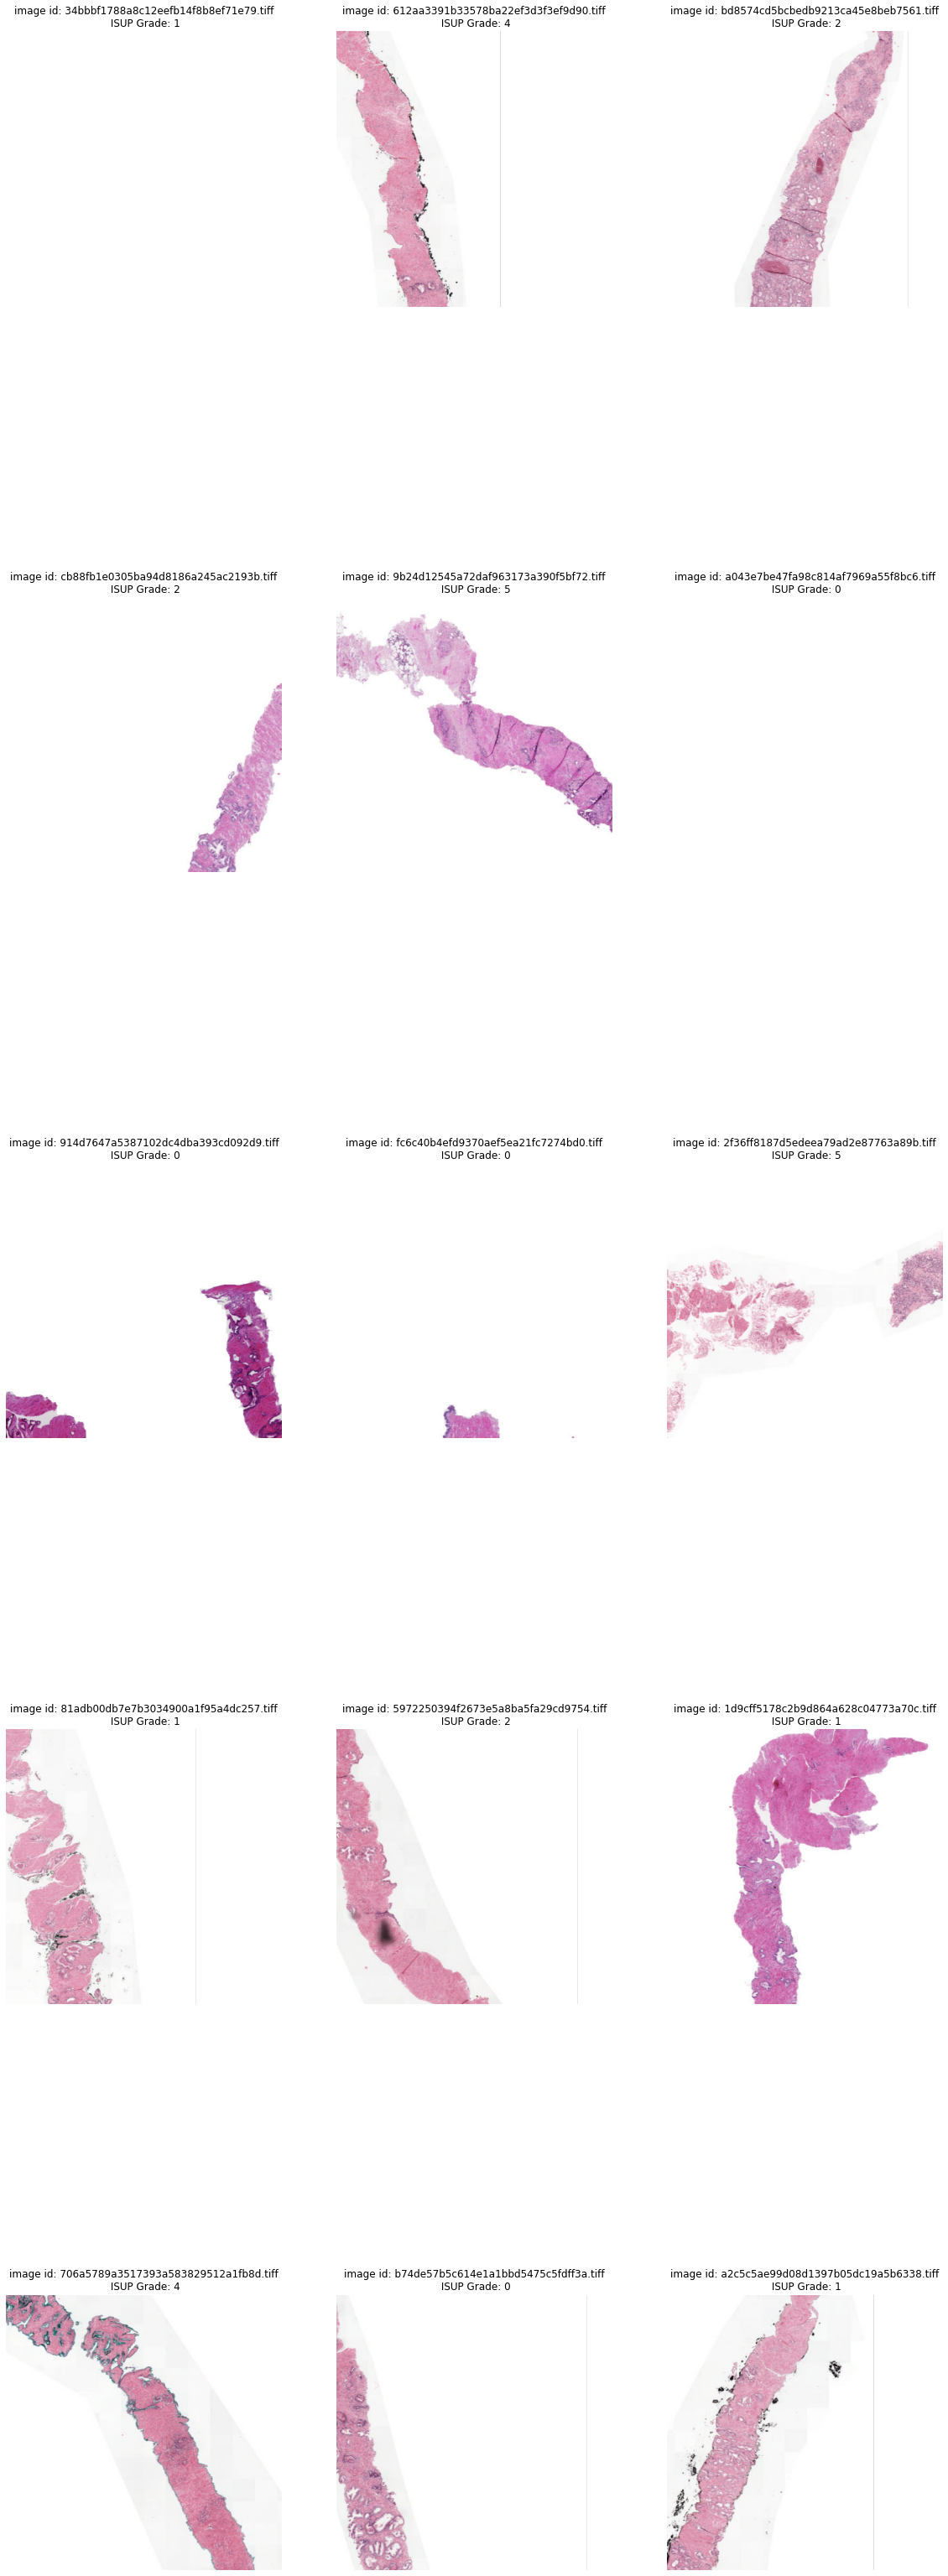

In [14]:
TIFFVisualization.visualize_patch((512, 512), 15, np.random.randint(1759, 1800, (2,)), IMAGES_DIR, train_df_copy, 0)

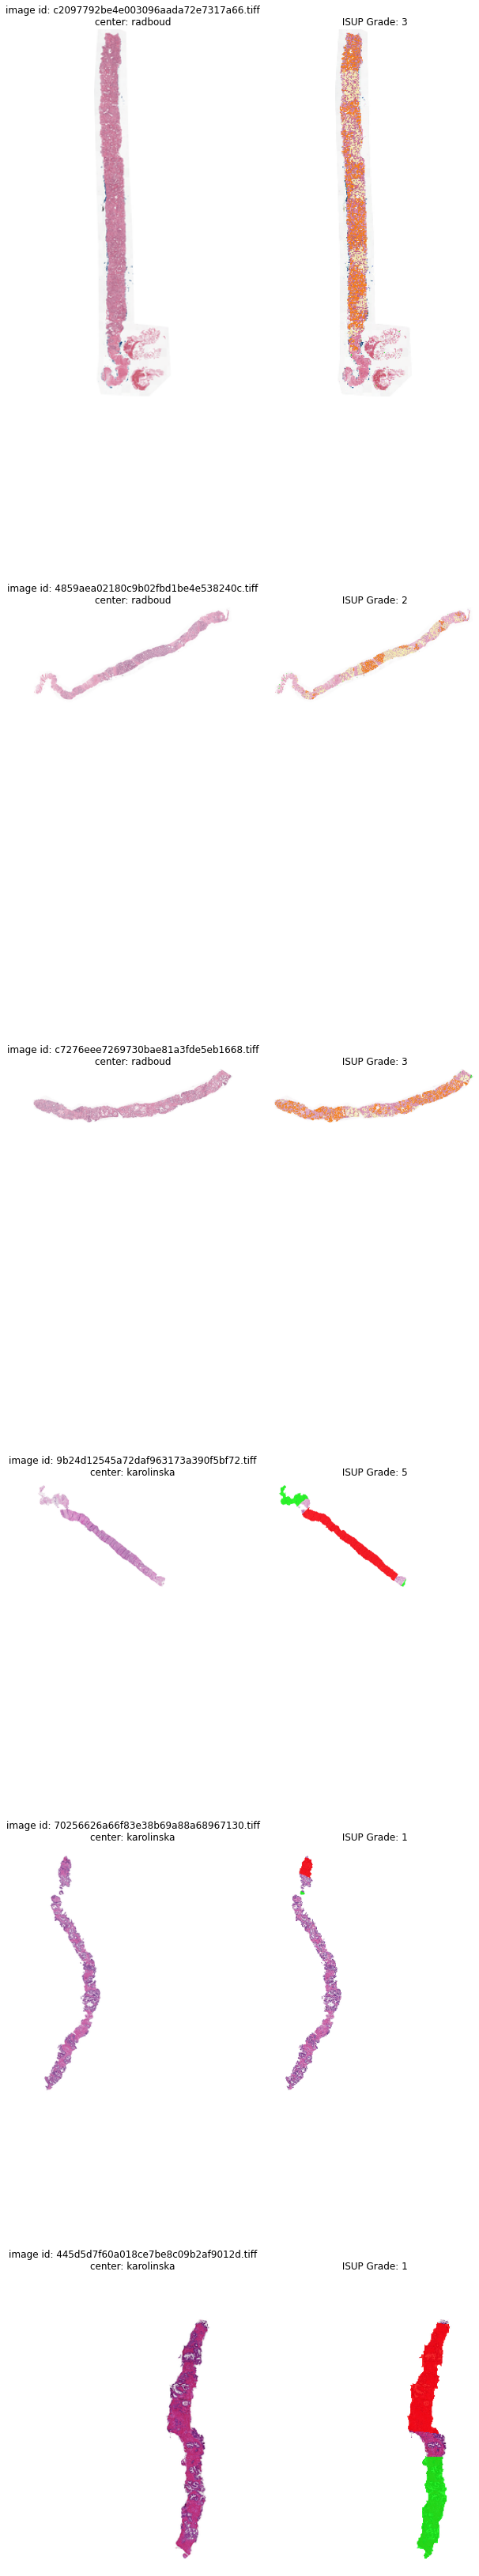

In [15]:
TIFFVisualization.visualize_masks(6, MASK_DIR, IMAGES_DIR, train_df_copy,)

## Extracting patches from the slide and it's mask

In [16]:
img = openslide.OpenSlide('/content/PANDA_subset/train_images_subset/81adb00db7e7b3034900a1f95a4dc257.tiff')
img_data = img.read_region((0, 0), 2, img.level_dimensions[2])
img_data = img_data.convert('RGB')
img_data = np.asarray(img_data, np.float32) / 255.0

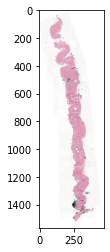

In [17]:
plt.imshow(img_data)

In [18]:
img_data = tf.expand_dims(img_data, 0)

In [19]:
print(img_data.shape)

(1, 1568, 464, 3)


In [20]:
patches = tf.image.extract_patches(img_data, (1, 128, 128, 1), (1, 128, 128, 1), (1, 1, 1, 1), 'VALID')
patches = tf.reshape(patches, (-1, 128, 128, 3))
patches.shape

TensorShape([36, 128, 128, 3])

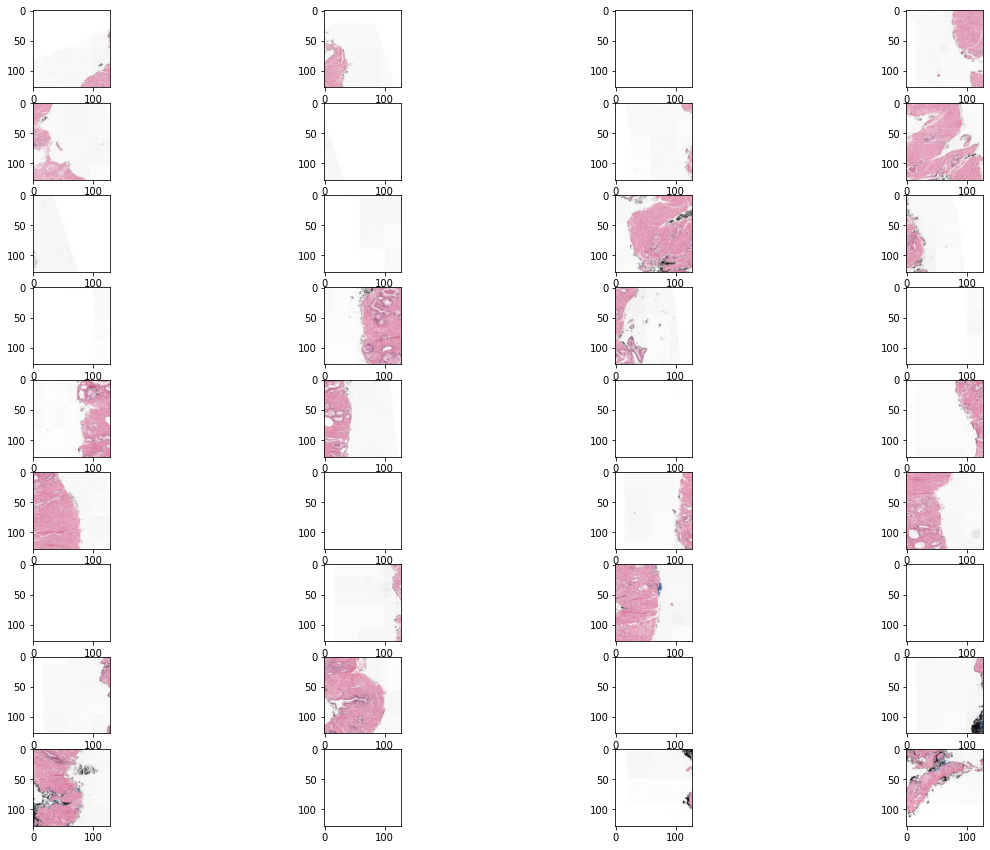

In [21]:
fig, axes = plt.subplots(9, 4, figsize=(20, 15))
for i in range(36):
  axes[i // 4][i % 4].imshow(patches[i])

In [22]:
mask = openslide.OpenSlide('/content/PANDA_subset/train_masks_subset/81adb00db7e7b3034900a1f95a4dc257_mask.tiff')
mask_data = mask.read_region((0, 0), 2, mask.level_dimensions[2])
mask_data = mask_data.convert('RGB')
mask_data = np.asarray(mask_data, np.float32)
mask_data = mask_data[:, :, 0]

In [23]:
mask_data.shape

(1568, 464)

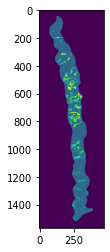

In [24]:
plt.imshow(mask_data)

In [25]:
mask_data = tf.expand_dims(mask_data, 0)
mask_data = tf.expand_dims(mask_data, -1)
patches = tf.image.extract_patches(mask_data, (1, 128, 128, 1), (1, 128, 128, 1), (1, 1, 1, 1), 'VALID')
patches = tf.reshape(patches, (-1, 128, 128, 1))
patches.shape

TensorShape([36, 128, 128, 1])

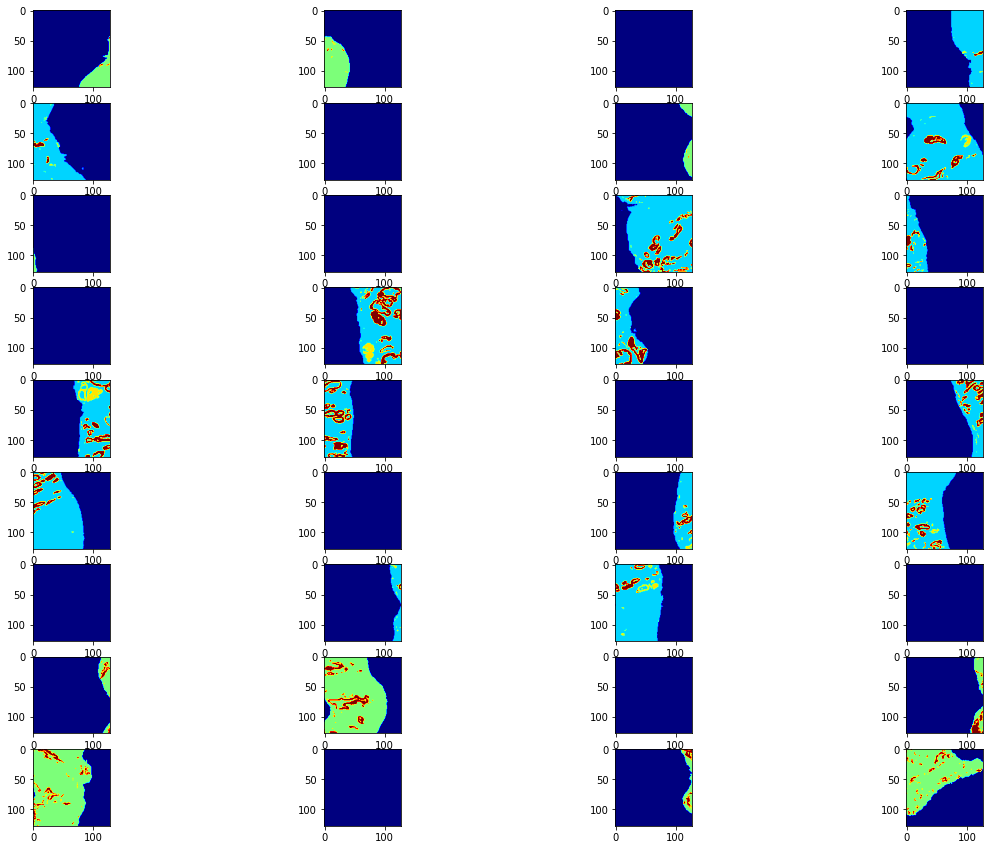

In [26]:
fig, axes = plt.subplots(9, 4, figsize=(20, 15))
for i in range(36):
  axes[i // 4][i % 4].imshow(tf.squeeze(patches[i]), cmap='jet')

# Custom DataGenerators for preparing the data for the task of pseudo segmentation of the tissue

---

## What is Pseudo Segmentation ?
Pseudo Segmentation is a process of creation of fake mask maps by using the classification approach on the entire image at the patch level. The entire slide image is broken down into patches of fixed length and these patches are then classified. If found positive, that patch in the original image is then masked, thereby, creating a fake mask map.

## Problems & some novel solutions!
1. One of the biggest concerns here is that only about 20% of the entire slide image is the tissue region(Region of Interest) and the rest is just the white slide itself. So most of the extracted patches will be showing the slide only and not the tissue.
> To solve this issue for the images whose masks have been given, we will be using the mapping provided by the dataset authors. The mask image contains this mapping in its R channel and the patches with only the "0" pixel value in it will be considered as slides and not the tissue.

2. After filtering the white background patches, there might be some patches where the tissue region is very insignificant. What to do in such cases?
> To address this issue, one parameter has been provided to the user which determines how much minimum percent tissue must be present in the slide to consider it valid.





In [27]:
class DataGenerator(tf.keras.utils.Sequence):
  
  def __init__(self,
               img_dir: str,
               mask_dir: str,
               df_images: pd.DataFrame, 
               batch_size: int, 
               patch_size: tuple,  
               level: int,
               tissue_threshold = 0.50,
               write_to_disk = False,
               save_format = None,
               save_prefix = "",
               is_training = True,
               ):
    
    if 0 > level > 2:
      raise ValueError(f"level should be in the range [0, 2].")
    
    if 0 > tissue_threshold > 1:
      raise ValueError(f"tissue_threshold should be in the range [0, 1].")
    
    if write_to_disk:
      if save_format is None:
        raise TypeError("save format should not be None")
    

    assert len(patch_size) == 2, "patch_size should be a 2D tupple."


    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.df = df_images
    self.patch_size = patch_size
    self.batch_size = batch_size
    self.level = level
    self.thresh = tissue_threshold
    self.training = is_training
    self.write_to_disk = write_to_disk
    self.save_format = save_format
    self.save_prefix = save_prefix
    self.down_sampling_scale = None


    self.indices = range(len(self.df))

    self.indexed_df = self.df.copy()
    self.indexed_df.set_index('image_id', inplace=True)
    


  def __len__(self):
    return len(self.df) // self.batch_size

  
  def __is_valid(self, unique):
    
    if len(unique[0]) > 1 and unique[1][0] / (self.patch_size[0] * self.patch_size[1]) < (1 - self.thresh):
      return True
    
    return False

  
  def __get_next_patch(self, image_id: str):
    mask_path = f'{self.mask_dir}/{image_id}_mask.tiff'
    image_path = f'{self.img_dir}/{image_id}.tiff'

    data_center = self.indexed_df.loc[image_id].data_provider   

    mask = openslide.OpenSlide(mask_path)
    img = openslide.OpenSlide(image_path)

    if self.down_sampling_scale is None:
      self.down_sampling_scale = {level: int(scaling_factor) for level, scaling_factor in enumerate(mask.level_downsamples)}

    width, height = mask.level_dimensions[self.level][0] // self.patch_size[0], mask.level_dimensions[self.level][1] // self.patch_size[1]

    scaling_factor = self.down_sampling_scale[self.level]

    for yidx in range(height):
      for xidx in range(width):
        mask_data = mask.read_region((xidx * self.patch_size[0] * scaling_factor, yidx * self.patch_size[1] * scaling_factor), 
                                     self.level, self.patch_size)
        mask_data = mask_data.convert('RGB')
        mask_data = np.asarray(mask_data, np.float32)
        mask_data = mask_data[:, :, 0]

        if data_center == 'radboud':
          mask_data[mask_data == 2.0] = 1.0
        
        unique = np.unique(mask_data, return_counts=True)


        if self.__is_valid(unique):
          img_data = img.read_region((xidx * self.patch_size[0] * scaling_factor, yidx * self.patch_size[1] * scaling_factor), 
                                     self.level, self.patch_size)
          img_data = img_data.convert('RGB')
          img_data = np.asarray(img_data, np.float32) / 255.0
          label = 0 if unique[1][-1] < 2 else 1
          yield img_data, label
    
    img.close()
    mask.close()


  def __get_patches(self, image_id):
    # start = time.time()
    next_patch = self.__get_next_patch(image_id)

    patches, labels = [], []

    for patch, label in next_patch:
      patches.append(patch)
      labels.append(label)
    
    # print(time.time() - start)
    return tf.stack(patches), tf.stack(labels)


  def __getitem__(self, idx):
    batch_indices = self.indices[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_image_ids = self.df['image_id'].iloc[batch_indices].values

    batch_training_data = [self.__get_patches(image_id) for image_id in batch_image_ids]

    batch_patches = [data[0] for data in batch_training_data]
    batch_labels = [data[1] for data in batch_training_data]

    batch_patches = tf.concat(batch_patches, axis=0)
    batch_labels = tf.concat(batch_labels, axis=0)

    # print(batch_patches.shape, batch_labels.shape)
    return batch_patches, batch_labels


In [28]:
BATCH_SIZE = 8
PATCH_SIZE = (512, 512)
INDEX_LEVEL = 0
TISSUE_THRESHOLD = 0.5

In [29]:
train_datagen = DataGenerator(img_dir=IMAGES_DIR,
                   mask_dir=MASK_DIR,
                   df_images=train_df,
                   batch_size=BATCH_SIZE,
                   patch_size=PATCH_SIZE,
                   level=INDEX_LEVEL,
                   tissue_threshold=TISSUE_THRESHOLD,
                   write_to_disk = False,
                   save_format = None,
                   save_prefix = "",
                   is_training=True)

validation_datagen = DataGenerator(img_dir=IMAGES_DIR,
                   mask_dir=MASK_DIR,
                   df_images=validation_df,
                   batch_size=BATCH_SIZE,
                   patch_size=PATCH_SIZE,
                   level=INDEX_LEVEL,
                   tissue_threshold=TISSUE_THRESHOLD,
                   write_to_disk = False,
                   save_format = None,
                   save_prefix = "",
                   is_training=False)

## Benchmarking the DataGenerators

In [30]:
def get_gen_train() -> DataGenerator:
    train_datagen = DataGenerator(img_dir=IMAGES_DIR,
                   mask_dir=MASK_DIR,
                   df_images=train_df,
                   batch_size=8,
                   target_size=(1568, 464),
                   patch_size=(128, 128),
                   level=2,
                   tissue_threshold=0.35,
                   is_training=True)
    
    return train_datagen
  
def get_gen_val() -> DataGenerator:
    validation_datagen = DataGenerator(img_dir=IMAGES_DIR,
                   mask_dir=MASK_DIR,
                   df_images=validation_df,
                   batch_size=8,
                   target_size=(1568, 464),
                   patch_size=(128, 128),
                   level=2,
                   tissue_threshold=0.35,
                   is_training=False)
    
    return validation_datagen
  

train_datagen1 = tf.data.Dataset.from_generator(get_gen_train, 
                                          output_signature=(tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(None, 2), dtype=tf.int32)))

train_datagen1 = train_datagen1.prefetch(1)

validation_datagen1 = tf.data.Dataset.from_generator(get_gen_train, 
                                          output_signature=(tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(None, 2), dtype=tf.int32)))

validation_datagen1 = validation_datagen1.prefetch(1)


tfds.core.benchmark(train_datagen1)

0it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 0.71 ex/sec (total: 8 ex, 11.19 sec)
Examples/sec (First only) 0.84 ex/sec (total: 1 ex, 1.19 sec)
Examples/sec (First excluded) 0.70 ex/sec (total: 7 ex, 10.00 sec)


{'first': {'avg': 0.8382977908328986,
  'duration': 1.192893517000016,
  'num_examples': 1},
 'first+last': {'avg': 0.7146306257803557,
  'duration': 11.194594397999992,
  'num_examples': 8},
 'last': {'avg': 0.699880958577531,
  'duration': 10.001700880999977,
  'num_examples': 7},
 'raw': {'end_time': 308.54875359,
  'first_batch_time': 298.547052709,
  'num_iter': 8,
  'start_time': 297.354159192}}

In [31]:
# test = next(iter(train_datagen))

# Model Building

In [36]:
model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, 
                                                       input_shape=(128, 128, 3))
def build_model(pre_trained_model: tf.keras.Model) -> tf.keras.Model:
    """Returns the model architecture for transfer learning.
    """
    for layer in pre_trained_model.layers:
        layer.trainable=False
    
    
    
    x = pre_trained_model.outputs[0]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[pre_trained_model.inputs], outputs=[outputs], name='baseline_model')
    return model

model = build_model(model)

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, mode='min', restore_best_weights=True, verbose=1
)

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
             metrics=METRICS)

219070464/219055592 [==============================] - 2s 0us/step


In [37]:
history = model.fit(train_datagen, epochs=100, verbose=1, callbacks=[early_stopping], validation_data=validation_datagen)

Epoch 1/100
8/8 [==============================] - 35s 3s/step - loss: 2.1355 - tp: 191.0000 - fp: 115.0000 - tn: 191.0000 - fn: 115.0000 - accuracy: 0.6242 - precision: 0.6242 - recall: 0.6242 - auc: 0.7031 - prc: 0.6779 - val_loss: 0.6390 - val_tp: 73.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 25.0000 - val_accuracy: 0.7449 - val_precision: 0.7449 - val_recall: 0.7449 - val_auc: 0.7422 - val_prc: 0.7229
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 0.6959 - tp: 200.0000 - fp: 106.0000 - tn: 200.0000 - fn: 106.0000 - accuracy: 0.6536 - precision: 0.6536 - recall: 0.6536 - auc: 0.7057 - prc: 0.6905 - val_loss: 0.7793 - val_tp: 76.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 22.0000 - val_accuracy: 0.7755 - val_precision: 0.7755 - val_recall: 0.7755 - val_auc: 0.7567 - val_prc: 0.7078
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 0.5398 - tp: 231.0000 - fp: 75.0000 - tn: 231.0000 - fn: 75.0000 - accuracy: 0.7549 - precision

# Inference

Getting Infernece...: 100%|██████████| 15/15 [00:01<00:00, 10.30it/s]


Diagnosis: malignant


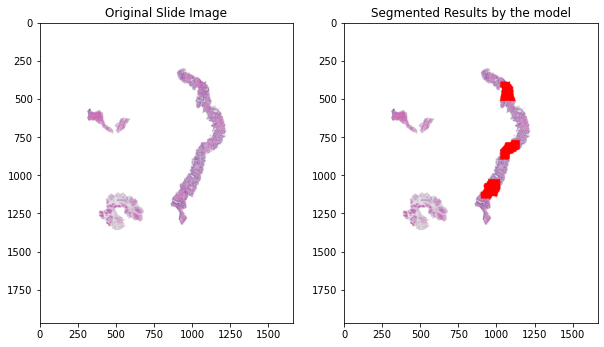

In [47]:
def get_inference(slide_path: str, index_level: int, model: tf.keras.Model, patch_size: tuple, tissue_threshold=0.35, segmented_results=False):
  """Diagnoses and segments the slide.
  
  Args:
      slide_path: str. file path to read the image.
      index_level: int. Should be in the range[0, 2]. Indicates from which resolution level the patch has to be extracted.
      model: tf.keras.Model. Trained model instance.
      patch_size: tuple. 2D-tuple. (x-length, y-length). Image will be divided into patches of the desired size.
                         Example : (128, 128), Output will be of shape (-1, 128, 128, channels).
      tissue_threshold: float. Should be in range[0, 1]. percentage of tissue region in a patch to consider that patch to be valid.
      segmented_results: bool. If True, fake-masks will be mapped to the original image. If False, only the diagnosis will be provided.
  
  Raises:
      ValueError: If `index_level` is not in range [0, 2].
      ValueError: If `tissue_threshold` is not a fraction in range [0, 1].
      AssertionError: If `patch_size` is not a 2D-tupple.
  """ 
  p_bar=tqdm(total = 15, desc = "Getting Infernece...")
  # print('Testing Constarints..../', end=" ")
  
  if 0 > index_level > 2:
    raise ValueError(f"index_level should be in the range [0, 2].")
    
  if 0 > tissue_threshold > 1:
    raise ValueError(f"tissue_threshold should be in the range [0, 1].")

  assert len(patch_size) == 2, "patch_size should be a 2D tupple."

  # print('\rAccessing the image to read..../', end=" ")
  p_bar.update(1)


  img = openslide.OpenSlide(slide_path)
  img_data = img.read_region((0, 0), index_level, img.level_dimensions[index_level])
  img_data = img_data.convert('RGB')
  img_data = np.asarray(img_data, np.float32) / 255.0
  img_data = tf.expand_dims(img_data, 0)
  img.close()

  p_bar.update(2)
  # print('\rExtracting the patches..../', end=" ")


  patch = (1, patch_size[0], patch_size[1], 1)

  batch_patches = tf.image.extract_patches(img_data, patch, patch, 
                                             [1, 1, 1, 1], padding='VALID')
    
  batch_patches = tf.reshape(batch_patches, (-1,patch_size[0], patch_size[1], 3))

  p_bar.update(3)
  # print('\rValidting the patches..../', end=" ")




  tissue_regions_ind = [i for i in range(batch_patches.shape[0]) if np.unique(batch_patches[i])[0] < 0.75
                        and np.sum(np.unique(batch_patches[i][batch_patches[i] > 0.75], return_counts=True)[1]) / 
                        (patch_size[0] * patch_size[1] * 3) < (1 - tissue_threshold)]
  
  tissue_regions = tf.stack(batch_patches.numpy()[tissue_regions_ind])

  p_bar.update(4)
  # print('\rDiagnosing..../', end=" ")



  preds = np.argmax(model.predict(tissue_regions), axis=1)
  img_data = np.squeeze(img_data.numpy())
  copy_img_data = img_data.copy()
  loc_ind = img_data.shape[1] // patch_size[1]
  diagnosis = 'banign'

  if np.sum(preds > 0):
    diagnosis = 'malignant'
  
  p_bar.update(2)
  # print('\rFetching the final results..../')

  if segmented_results:
    for ind, res in enumerate(tissue_regions_ind):
      if preds[ind] == 1:
        row, col = res // loc_ind, res % loc_ind
        roi = img_data[row * patch_size[0] : (row + 1) * patch_size[0], col * patch_size[1]: (col + 1) * patch_size[1], :]
        roi[roi[:, :, 0] < 0.93] = (1, 0, 0)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(copy_img_data)
    axes[0].set_title('Original Slide Image')

    axes[1].imshow(img_data)
    axes[1].set_title('Segmented Results by the model')

    
  p_bar.update(3)
  print(f'Diagnosis: {diagnosis}')
  p_bar.close()

get_inference('/content/PANDA_subset/train_images_subset/fc6c40b4efd9370aef5ea21fc7274bd0.tiff', 2, model, (128, 128),segmented_results=True)

In [48]:
# model.save('PANDA_pseudo_segmentation.h5') # save the model